# Automatyczna klasyfikacja terenu z wykorzystaniem uczenia maszynowego

Zrodlo danych: Sentinel T34UDE_20200815T095039
Kroki wykonane przed analizą:
* Zmiana formatu warstw z jp2 na png ze względu na bezproblemową współpracę z OpenCV
* Klasyfikacja terenu z QGIS oraz wtyczkę QuickOSM
 ** water
 ** forest
 ** farmland
* Dla każdego typu terenu utworzono maskę w formie obrazu PNG o rozdzielczości zgodnej z danymi wejściowymi
* Utworzenie pliku konfiguracyjnego config.ini

#### Wczytanie bibliotek

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from configparser import ConfigParser

In [2]:
import preprocesing as pre
import helpers as hlp

#### Wczytanie danyc z pliku konfiguracyjnego

In [3]:
config = ConfigParser()
config.read('config.ini')
input_dir = config['main']['input_dir']# Folder ze zdjęciami z Sentinela
classes_file = config['main']['classification_data']# Folder z maskami klas

Zdjęcia o rozdzielczości 10m składają sie z ponad 100 milionów pikseli
zatem do analizy wykorzystam tylko jego fragment o rozmiarze dx na dy
i zaczynający się od piksela (x_star, y_start)

In [4]:
dx = int(config['main']['x_size'])
dy = int(config['main']['y_size'])
x_start = int(config['main']['x_start'])
y_start = int(config['main']['y_start'])
csv_data_file = config['main']['csv_data_file']

#### Przekształcamy dane wejściowe w coś przyjemniejszego do analizy

In [5]:
data, columns_names = pre.images_to_numpy(input_dir, dx, dy, x_start, y_start)

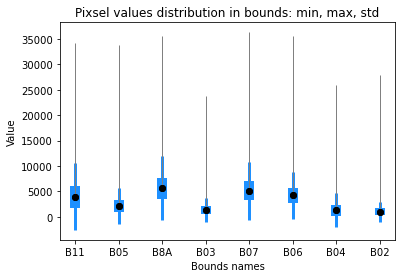

In [6]:
hlp.plot_MinMaxAvg(data, columns_names)

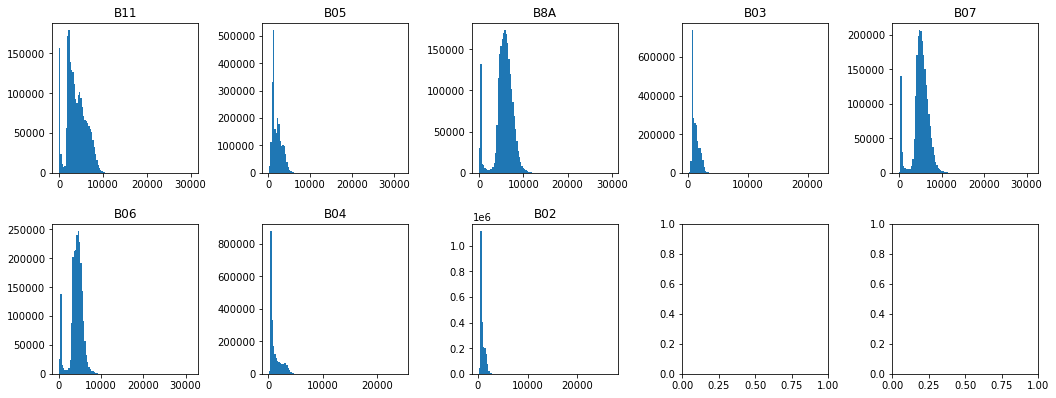

In [7]:
hlp.plot_values_histogram(data, columns_names, ncols=5)

Rozkład wartości pikseli wskazuje na występowanie wartości odstających zatem przekształćmy je w następujący sposób: $ x = min(x,\overline{x}+3\sigma_{x}) $ oraz przeskalujmy z wykorzystaniem minmaxscaler z sklearn.

In [8]:
data = pre.remove_outstandings(data)

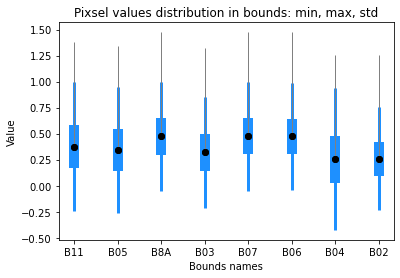

In [9]:
hlp.plot_MinMaxAvg(data, columns_names)

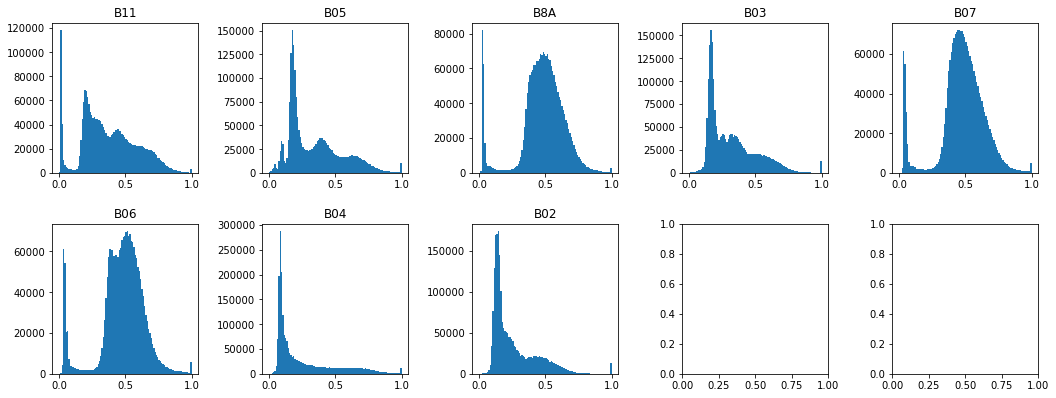

In [10]:
hlp.plot_values_histogram(data, columns_names, ncols=5)

#### Wczytajmy teraz maski klas oraz stwórzmy klasę "other"

In [11]:
classes, classes_names = pre.get_classes(classes_file, dx, dy, x_start, y_start)
other = (1 - classes.any(axis=1).astype(int)).reshape(-1,1)
classes_names += ['other']
pre.add_classes_to_config(config, classes_names)
columns_names += classes_names 
nr_of_classes = len(classes_names)

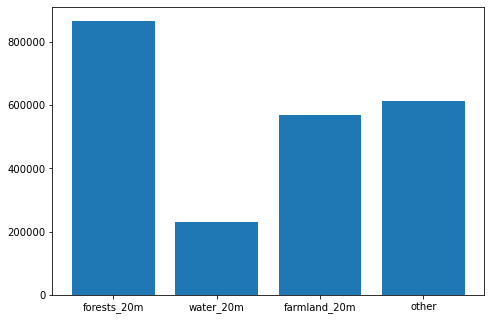

In [12]:
hlp.show_classes_distribution(np.concatenate((classes, other), axis=1),classes_names)

In [13]:
data = np.concatenate((data, classes, other), axis=1)
data = pd.DataFrame(data, columns=columns_names)
data[classes_names] = data[classes_names].astype('int')

In [14]:
data.head()

,B11,B05,B8A,B03,B07,B06,B04,B02,forests_20m,water_20m,farmland_20m,other
0,0.440603,0.386630,0.645901,0.369597,0.661327,0.663753,0.202025,0.257712,0,0,0,1
1,0.440603,0.396921,0.612562,0.377876,0.623558,0.656645,0.217221,0.264246,0,0,0,1
2,0.412196,0.386630,0.710221,0.353039,0.731866,0.734828,0.148837,0.221415,0,0,0,1
3,0.396752,0.368254,0.797778,0.340620,0.862576,0.864140,0.111739,0.201814,0,0,0,1
4,0.398278,0.362742,0.820678,0.350673,0.848505,0.866891,0.109952,0.193829,0,0,0,1


Dane zostały przygotowane zapisujemy je i możemy zająć się klasyfikacją

In [15]:
data.to_csv(csv_data_file)

#### Dzielimy dane

In [16]:
X = data.iloc[:,1:-nr_of_classes].to_numpy()
Y = data.iloc[:,-nr_of_classes:].to_numpy()
Y_2D = Y.reshape((dx,dy,nr_of_classes)) 

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Klasyfikacja obszaru z wykorzystaniem lasów losowych

#### Trenowanie

In [18]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)

RandomForestClassifier()

#### Testowanie

In [19]:
Y_pred_RF = clf.predict(X_test)

In [20]:
print("Random forest acc: ",accuracy_score(Y_test, Y_pred_RF))

Random forest acc:  0.8128074074074074


#### Wizualizacja wyników

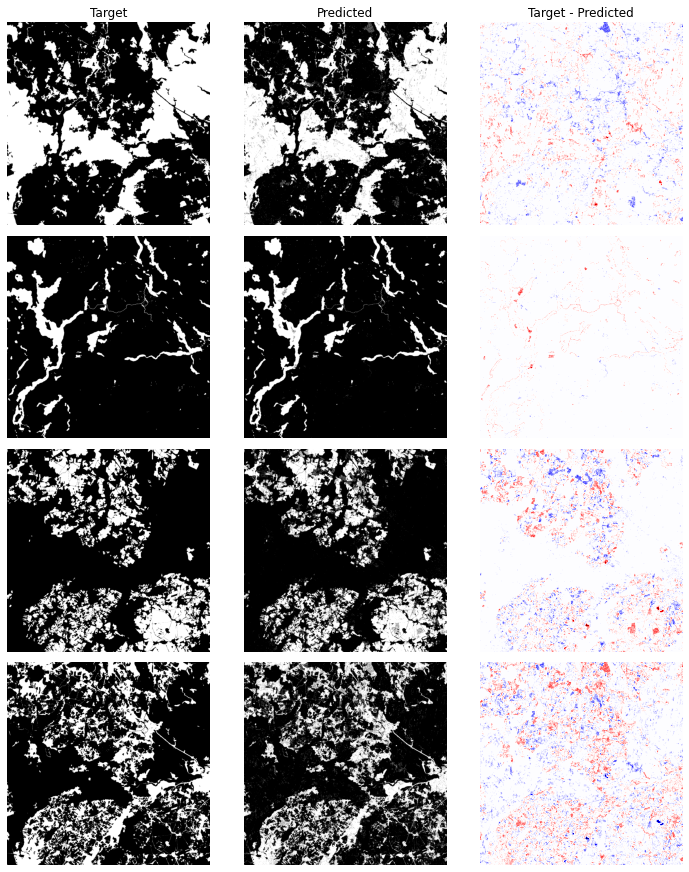

In [21]:
Y_pred_RF = clf.predict(X)
Y_pred_RF = np.rint(Y_pred_RF)
hlp.show_target_pred_dif(Y_2D, Y_pred_RF.reshape((dx, dy, nr_of_classes)))

# Klasyfikacja obszaru z wykorzystaniem sieci neuronowych

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [23]:
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 50,756
Trainable params: 50,756
Non-trainable params: 0
____________________________________________________

In [25]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
model.fit(X_train, Y_train, epochs=20, batch_size=10000)

Epoch 1/10
1575/1575 [==============================] - 3s 2ms/step - loss: 0.2537 - accuracy: 0.7878
Epoch 2/10
1575/1575 [==============================] - 3s 2ms/step - loss: 0.2296 - accuracy: 0.8097
Epoch 3/10
1575/1575 [==============================] - 2s 2ms/step - loss: 0.2258 - accuracy: 0.8127
Epoch 4/10
1575/1575 [==============================] - 2s 2ms/step - loss: 0.2237 - accuracy: 0.8145
Epoch 5/10
1575/1575 [==============================] - 2s 2ms/step - loss: 0.2226 - accuracy: 0.8154
Epoch 6/10
1575/1575 [==============================] - 2s 2ms/step - loss: 0.2217 - accuracy: 0.8160
Epoch 7/10
1575/1575 [==============================] - 3s 2ms/step - loss: 0.2208 - accuracy: 0.8166
Epoch 8/10
1575/1575 [==============================] - 2s 2ms/step - loss: 0.2203 - accuracy: 0.8171
Epoch 9/10
1575/1575 [==============================] - 3s 2ms/step - loss: 0.2197 - accuracy: 0.8176
Epoch 10/10
1575/1575 [==============================] - 3s 2ms/step - loss: 0.219

In [27]:
_, accuracy = model.evaluate(X_test, Y_test)
print(f'Deap learning acc: {accuracy}')

21094/21094 [==============================] - 27s 1ms/step - loss: 0.2106 - accuracy: 0.8247
Deap learning acc: 0.8246577978134155


#### Wizualizacja wyników

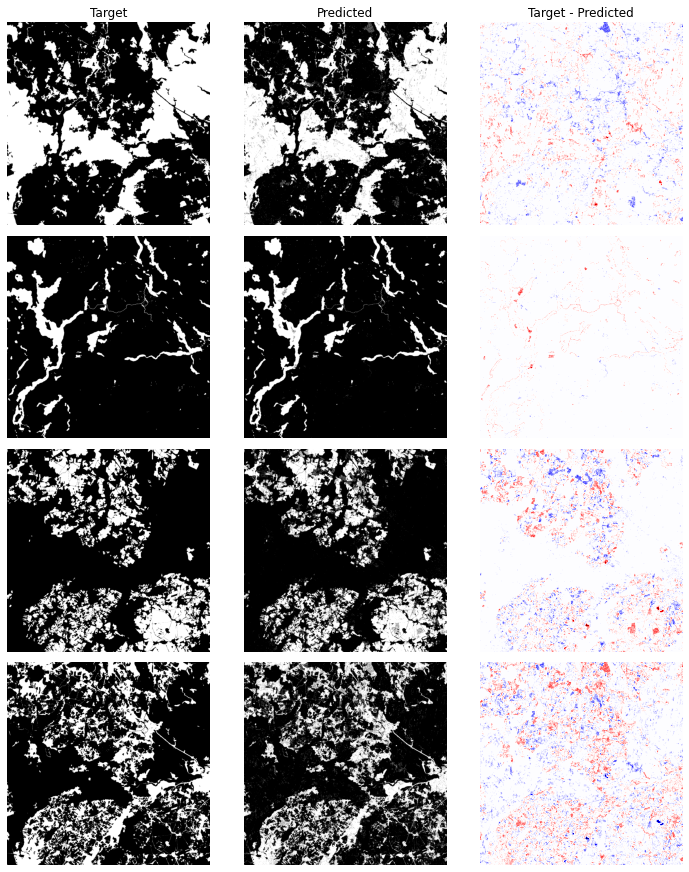

In [28]:
Y_pred_DL = model.predict(X)
Y_pred_DL = np.rint(Y_pred_DL)
hlp.show_target_pred_dif(Y_2D,Y_pred_RF.reshape((dx, dy, nr_of_classes)))

# Klasyfikacja obszaru z wykorzystaniem samoorganizujących się map

In [29]:
from minisom import MiniSom
x_som, y_som = 5,5
som = MiniSom(x=x_som, y=y_som, input_len=X.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X)
som.train_random(X, num_iteration=10000, verbose=False)

#### rysujemy mapę

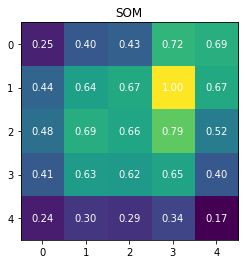

In [30]:
fig, ax = plt.subplots()
ax.set_title('SOM')
plt.imshow(som.distance_map())
for (i, j), z in np.ndenumerate(som.distance_map()):
    ax.text(j, i, '{:0.2f}'.format(som.distance_map()[i,j]), ha='center', va='center',color = 'white')

#### Klasyfikujemy
Każdemu punktowi możemy przypisać jeden z neuronów mapy

In [31]:
Y_pred_SOM = [som.winner(x) for x in X]
Y_pred_SOM = np.array([i[0]*100 + i[1] for i in Y_pred_SOM ])

#### One Hot Encode

In [32]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
Y_pred_SOM = enc.fit_transform(Y_pred_SOM.reshape(-1, 1)).toarray()

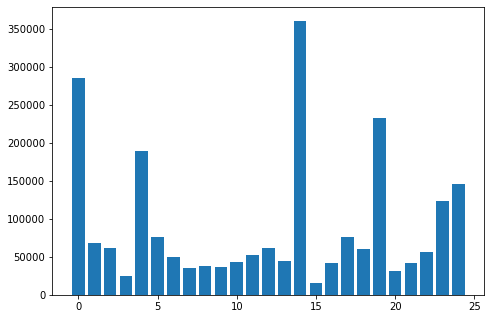

In [33]:
xxx = list(range(25))
hlp.show_classes_distribution(Y_pred_SOM, list(range(25)))

#### Walidacja

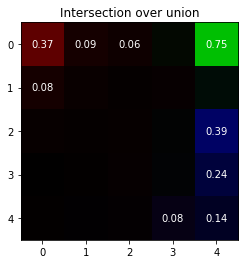

In [34]:
clusstered = np.zeros((x_som,y_som,3))
matrix_IoU = hlp.metrics_matrix(Y, Y_pred_SOM, hlp.IoU)
clusstered[...,2]=matrix_IoU[:,0].reshape((x_som,y_som))#Klasa 1 kolor niebieski
clusstered[...,1]=matrix_IoU[:,1].reshape((x_som,y_som))#Klasa 2 kolor zielony
clusstered[...,0]=matrix_IoU[:,2].reshape((x_som,y_som))#Klasa 3 kolor czerwony
fig, ax = plt.subplots()
ax.set_title('Intersection over union')
plt.imshow(clusstered)
for (i, j, k), z in np.ndenumerate(clusstered):
    if z > 0.05:
        ax.text(j, i, '{:0.2f}'.format(max(clusstered[i,j,:])), ha='center', va='center',color = 'white')

Kolorami oznaczono klasę którą reprezentują. Słabe wyniki spowodowane są dużo wyższą liczbą otrzymanych klas niż klas które mieliśmy początkowo.

In [35]:
best = [matrix_IoU[:,i].argsort()[-1] for i in range(3)]

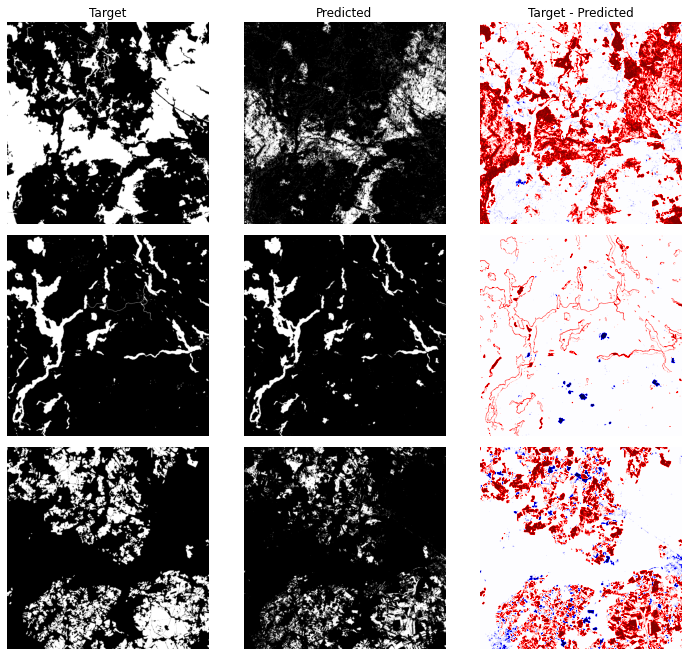

In [36]:
hlp.show_target_pred_dif(Y_2D[...,:-1], Y_pred_SOM.reshape((dx,dy,Y_pred_SOM.shape[1]))[...,best])

# Porównanie skuteczności algorytmów

In [37]:
Y_RF = clf.predict(X)

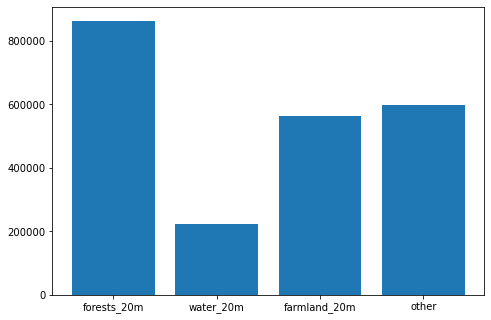

In [38]:
hlp.show_classes_distribution(Y_RF, classes_names)

In [39]:
Y_DL = model.predict(X)

In [40]:
Y_DL = np.rint(Y_DL)

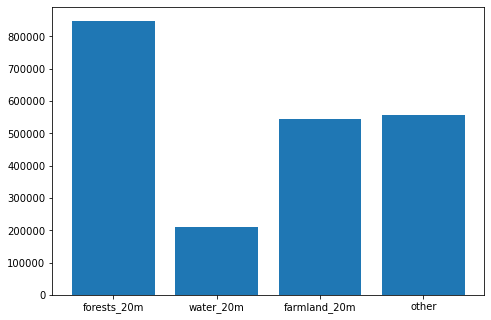

In [41]:
hlp.show_classes_distribution(Y_DL, classes_names)

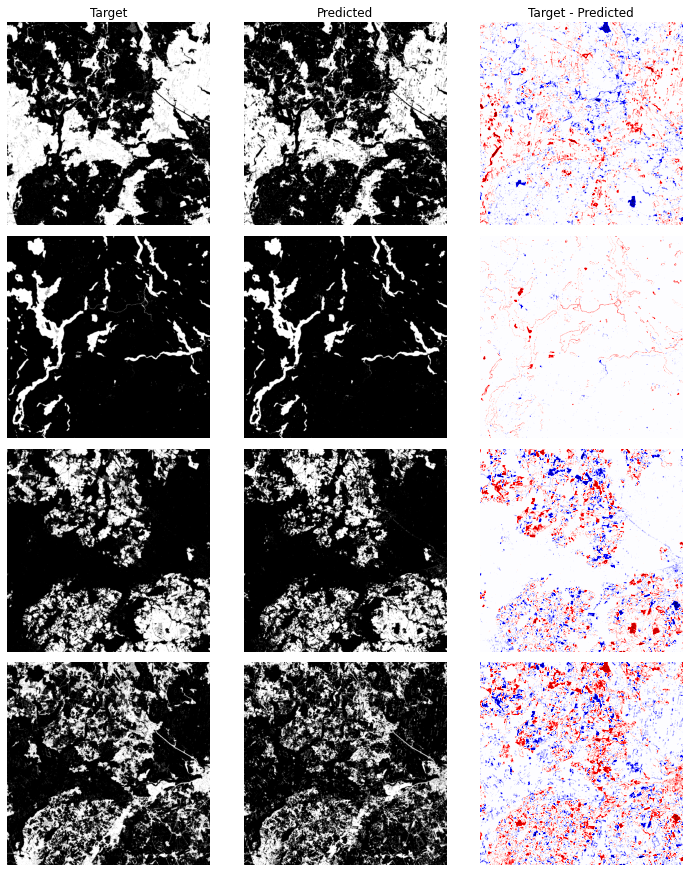

In [42]:
hlp.show_target_pred_dif(Y_RF.reshape((dx,dy,nr_of_classes)),Y_DL.reshape((dx,dy,nr_of_classes)))

# Analiza wyników